<a href="https://colab.research.google.com/github/Faraz011/Assignment-AIML-Lab/blob/main/Dynamic_Pricing_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [248]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split



reading data form source file

In [249]:
data = pd.read_csv('data.csv')
print(data.head())

         date  year  month  day_of_week  day_of_month  week_of_year  quarter  \
0  2020-01-01  2020      1            3             1             1        1   
1  2020-01-01  2020      1            3             1             1        1   
2  2020-01-01  2020      1            3             1             1        1   
3  2020-01-02  2020      1            4             2             1        1   
4  2020-01-02  2020      1            4             2             1        1   

    day_name month_name  season  ...  price_difference price_advantage  \
0  Wednesday    January  Winter  ...             -0.04               1   
1  Wednesday    January  Winter  ...              0.52               0   
2  Wednesday    January  Winter  ...              1.27               0   
3   Thursday    January  Winter  ...             -0.71               1   
4   Thursday    January  Winter  ...             -0.75               1   

   price_ratio_vs_competitor starting_inventory  ending_inventory  restock

Data preprocessing and Feature Engineering

In [250]:
numeric_feat = data.select_dtypes(include = ['int64','float64']).columns


In [251]:
skewness = data[numeric_feat].skew()
print(skewness.sort_values(ascending = False))

demand_shock                 9.331092
is_holiday                   3.454220
stockout                     2.553046
demand                       2.196976
restocked                    2.127229
is_promotion                 2.023521
revenue                      1.536622
is_weekend                   0.951068
ending_inventory             0.863663
starting_inventory           0.810312
competitor_price             0.398402
own_price                    0.309400
price_ratio_vs_competitor    0.162447
year                         0.086362
price_advantage              0.056041
quarter                      0.031676
week_of_year                 0.026061
month                        0.017617
day_of_month                 0.014588
day_of_week                  0.000917
price_difference            -0.502031
dtype: float64


In [252]:
skewed_feat = skewness[abs(skewness) > 0.1].index
print(skewed_feat)

Index(['is_weekend', 'is_holiday', 'is_promotion', 'own_price',
       'competitor_price', 'price_difference', 'price_ratio_vs_competitor',
       'starting_inventory', 'ending_inventory', 'restocked', 'stockout',
       'demand', 'demand_shock', 'revenue'],
      dtype='object')


In [253]:
data['revenue'] = np.log1p(data['revenue'])
data['price_difference'] = np.log1p(data['price_difference'])

In [254]:
print (data['price_difference'].head())
print (data['revenue'].head())

0   -0.040822
1    0.418710
2    0.819780
3   -1.237874
4   -1.386294
Name: price_difference, dtype: float64
0    7.021111
1    7.380081
2    6.257342
3    6.911847
4    6.945764
Name: revenue, dtype: float64


In [255]:
data['price_x_promotion'] = data['own_price'] * data['is_promotion']
data['price_x_weekend'] = data['own_price'] * data['is_weekend']


print(data.head())

         date  year  month  day_of_week  day_of_month  week_of_year  quarter  \
0  2020-01-01  2020      1            3             1             1        1   
1  2020-01-01  2020      1            3             1             1        1   
2  2020-01-01  2020      1            3             1             1        1   
3  2020-01-02  2020      1            4             2             1        1   
4  2020-01-02  2020      1            4             2             1        1   

    day_name month_name  season  ...  price_ratio_vs_competitor  \
0  Wednesday    January  Winter  ...                   0.998822   
1  Wednesday    January  Winter  ...                   1.013815   
2  Wednesday    January  Winter  ...                   1.070477   
3   Thursday    January  Winter  ...                   0.975826   
4   Thursday    January  Winter  ...                   0.984349   

  starting_inventory  ending_inventory restocked  stockout  demand  \
0                500               467        

In [295]:
split_indx = int(len(data) * 0.8)
train_data = data[:split_indx]
test_data = data[split_indx:]

X_train = train_data[[
     'competitor_price', 'is_promotion','price_ratio_vs_competitor',
    'price_x_promotion', 'is_weekend', 'day_of_week', 'month', 'demand'
]]
y_train = train_data['own_price']
X_test = test_data[[
     'competitor_price', 'is_promotion', 'price_ratio_vs_competitor'
    ,'price_x_promotion', 'is_weekend', 'day_of_week', 'month', 'demand'
]]
y_test = test_data['own_price']

In [296]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = PoissonRegressor(alpha = 0.1,max_iter = 1000)
model.fit(X_train_scaled, y_train)

PoissonRegressor(alpha=0.1, max_iter=1000)

In [297]:
from sklearn.metrics import accuracy_score
predict = model.predict(X_test_scaled)


In [298]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predict)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 2.470513739750113


In [299]:
mean = data['revenue'].mean()
print(f'Mean Revenue: {mean}')

Mean Revenue: 7.294554785652495


Implementing XGBoost

In [300]:
from xgboost import XGBRegressor, XGBClassifier
import shap

xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)



In [301]:
!pip install xgboost

In [302]:
model = xgb_model.fit(X_train, y_train)
predict1 = xgb_model.predict(X_test)

SHAP explanation

100%|===================| 3593/3600 [01:12<00:00]       

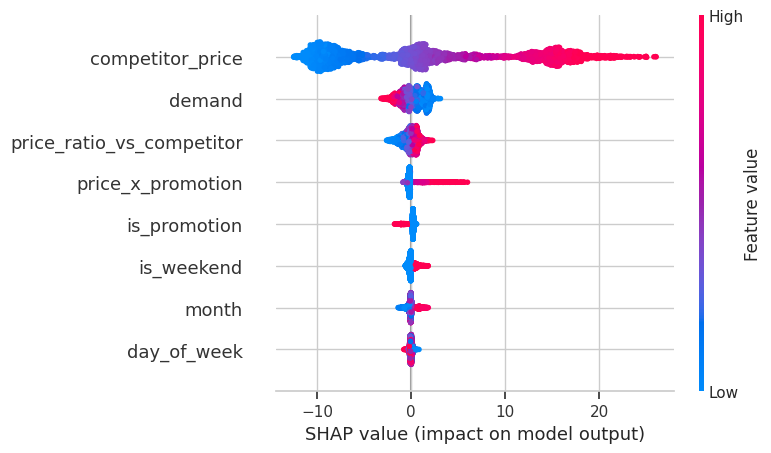

In [303]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# Visualize feature contributions
shap.summary_plot(shap_values, X_train)

In [264]:
mse1 = mean_squared_error(y_test, predict1)
print(f'Mean Squared Error: {mse1}')

Mean Squared Error: 0.0009311601629033063


In [265]:
rmse = np.sqrt(mse1)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.030514917055487898


In [266]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from xgboost import XGBRegressor, XGBClassifier


class PriceDemandPredictor:

    def __init__(self):
        self.price_model = None
        self.demand_model = None
        self.scaler_price = StandardScaler()
        self.scaler_demand = StandardScaler()

    def train_models(self, data):
        """Train both models on the same dataset"""

        # Clean data
        data = train_data.replace([np.inf, -np.inf], np.nan).dropna()

        # Numerical Encoding
        data['Product_num'] = pd.factorize(data['product_id'])[0]+1


        # Feature sets
        demand_features = data[['own_price','competitor_price','is_promotion','price_difference',
                                'price_x_promotion','is_weekend','day_of_week','month']]
        price_features = data[['competitor_price','is_promotion','price_difference','price_x_promotion',
                               'is_weekend','day_of_week','month','demand']]

        demand_target = data['demand']
        price_target = data['own_price']

        # Scale separately
        X_demand = self.scaler_demand.fit_transform(demand_features)
        X_price = self.scaler_price.fit_transform(price_features)

        # Train models
        self.price_model = PoissonRegressor(alpha=0.1, max_iter=1000)
        self.price_model.fit(X_price, price_target)

        self.demand_model = XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        self.demand_model.fit(X_demand, demand_target)

        print(" Models trained successfully on data.")
        return self

    def price_demand_prediction(self, data):
        """Predict new price and new demand on same dataset"""

        # Make a copy to avoid modifying original data
        data_copy = data.copy()
        data_copy = data_copy.replace([np.inf, -np.inf], np.nan).fillna(0)

        # Predict new price
        price_features = data_copy[['competitor_price','is_promotion','price_difference','price_x_promotion',
                               'is_weekend','day_of_week','month','demand']]
        X_price = self.scaler_price.transform(price_features)
        new_price = self.price_model.predict(X_price)


        data_copy['temp_price'] = new_price

        # Predict new demand using new price

        demand_features = data_copy[['temp_price','competitor_price','is_promotion','price_difference',
                                'price_x_promotion','is_weekend','day_of_week','month']].copy()
        demand_features = demand_features.rename(columns={'temp_price': 'own_price'})

        X_demand = self.scaler_demand.transform(demand_features)
        new_demand = self.demand_model.predict(X_demand)


        results = pd.DataFrame({
            'product_id': data['product_id'],
            'original_price': data['own_price'],
            'new_price': new_price,
            'original_demand': data['demand'],
            'new_demand': new_demand,
            'is_promotion': data['is_promotion'],

            'date': data['date'] if 'date' in data.columns else range(len(data))
        })

        print(" Predictions completed: ['new_price', 'new_demand']")
        return results




In [267]:
predictor = PriceDemandPredictor()
predictor.train_models(data)

 Models trained successfully on data.


In [268]:
results = predictor.price_demand_prediction(data)
price_pred = results['new_price']
demand_pred = results['new_demand']


print(f"Price predictions: {len(price_pred)} values")
print(f"Demand predictions: {len(demand_pred)} values")


print(results[['original_price', 'new_price', 'original_demand', 'new_demand']].head())


baseline_revenue = (results['original_price'] * results['original_demand']).sum()


optimized_revenue = (results['new_price'] * results['new_demand']).sum()

print("REVENUE COMPARISON:")
print(f"Baseline Revenue: ${baseline_revenue:,.2f}")
print(f"Optimized Revenue: ${optimized_revenue:,.2f}")


revenue_difference = optimized_revenue - baseline_revenue
uplift_percentage = (revenue_difference / baseline_revenue) * 100

print(f"Revenue Difference: ${revenue_difference:,.2f}")
print(f"Revenue Uplift: {uplift_percentage:.2f}%")


 Predictions completed: ['new_price', 'new_demand']
Price predictions: 4500 values
Demand predictions: 4500 values
   original_price  new_price  original_demand  new_demand
0           33.91  32.564545               33   33.127785
1           38.16  40.438644               42   45.255905
2           19.29  21.822536               27   40.053066
3           28.66  26.956029               35   56.013386
4           47.17  45.162490               22   30.964155
REVENUE COMPARISON:
Baseline Revenue: $7,317,044.55
Optimized Revenue: $9,436,117.34
Revenue Difference: $2,119,072.79
Revenue Uplift: 28.96%


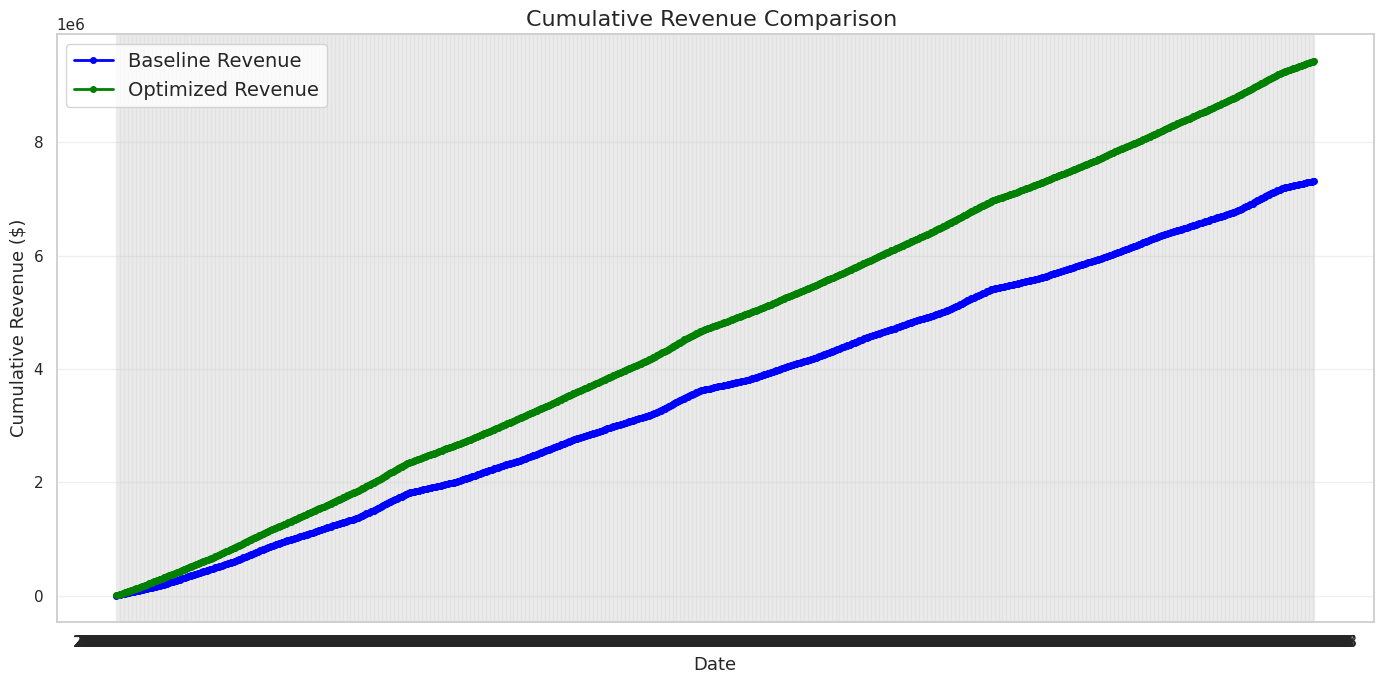

In [269]:
import matplotlib.pyplot as plt


if 'baseline_revenue' not in results.columns or 'optimized_revenue' not in results.columns:
    results['baseline_revenue'] = results['original_price'] * results['original_demand']
    results['optimized_revenue'] = results['new_price'] * results['new_demand']


results_sorted = results.sort_values(['date'])


revenue_by_date = results_sorted.groupby('date')[['baseline_revenue', 'optimized_revenue']].sum().reset_index()

revenue_by_date['cumulative_baseline'] = revenue_by_date['baseline_revenue'].cumsum()
revenue_by_date['cumulative_optimized'] = revenue_by_date['optimized_revenue'].cumsum()

plt.figure(figsize=(14, 7))
plt.plot(revenue_by_date['date'], revenue_by_date['cumulative_baseline'], label='Baseline Revenue', color='blue', linewidth=2, marker='o', markersize=4)
plt.plot(revenue_by_date['date'], revenue_by_date['cumulative_optimized'], label='Optimized Revenue', color='green', linewidth=2, marker='o', markersize=4)

plt.title('Cumulative Revenue Comparison ', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Cumulative Revenue ($)', fontsize=13)
plt.legend(loc='upper left', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()


plt.show()


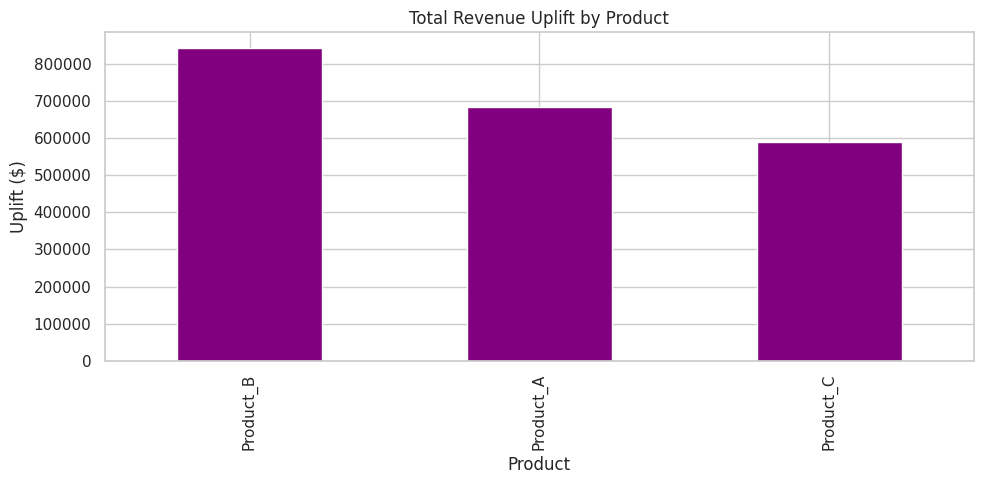

In [270]:
uplift_by_product = results.groupby('product_id')[['baseline_revenue','optimized_revenue']].sum()
uplift_by_product['uplift'] = uplift_by_product['optimized_revenue'] - uplift_by_product['baseline_revenue']

uplift_by_product['uplift_pct'] = (uplift_by_product['uplift'] / uplift_by_product['baseline_revenue'] * 100).round(1)
uplift_by_product = uplift_by_product.sort_values('uplift', ascending=False)

uplift_by_product['uplift'].plot(kind='bar', color='purple', figsize=(10,5))
plt.title('Total Revenue Uplift by Product')
plt.xlabel('Product')
plt.ylabel('Uplift ($)')
plt.tight_layout()
plt.show()


<Figure size 800x500 with 0 Axes>

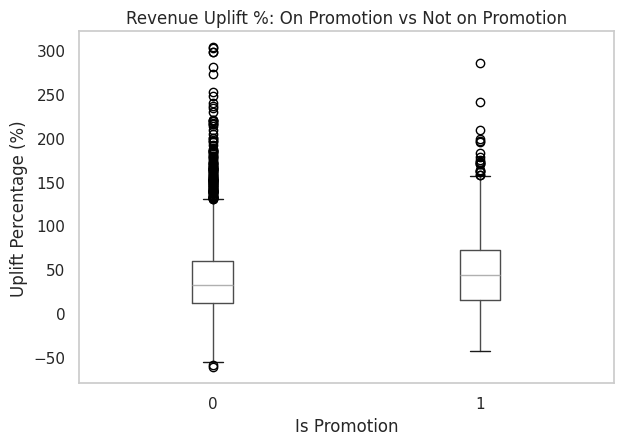

In [271]:
results['uplift_pct'] = (results['optimized_revenue'] - results['baseline_revenue']) / results['baseline_revenue'] * 100

plt.figure(figsize=(8,5))
results.boxplot(column='uplift_pct', by='is_promotion', grid=False)
plt.title('Revenue Uplift %: On Promotion vs Not on Promotion')
plt.suptitle('')
plt.xlabel('Is Promotion')
plt.ylabel('Uplift Percentage (%)')
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

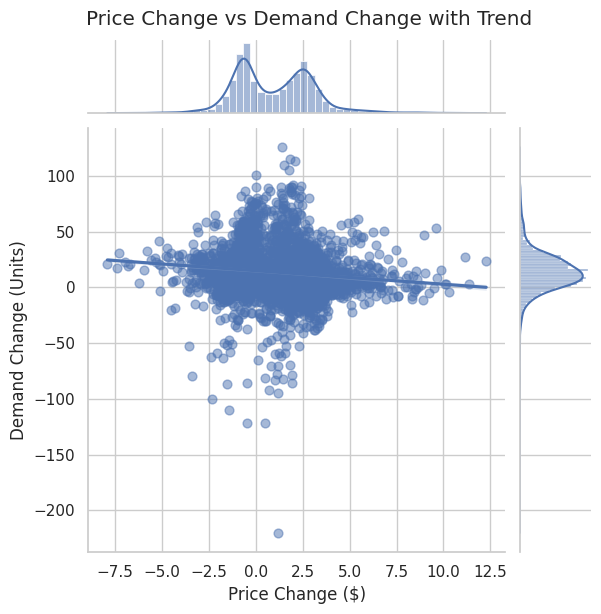

In [272]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.jointplot(
    x=results['new_price'] - results['original_price'],
    y=results['new_demand'] - results['original_demand'],
    kind='reg',
    height=6,
    scatter_kws={'alpha': 0.5, 's': 40}
)
plt.xlabel('Price Change ($)')
plt.ylabel('Demand Change (Units)')

plt.suptitle("Price Change vs Demand Change with Trend", y=1.02)
plt.show()


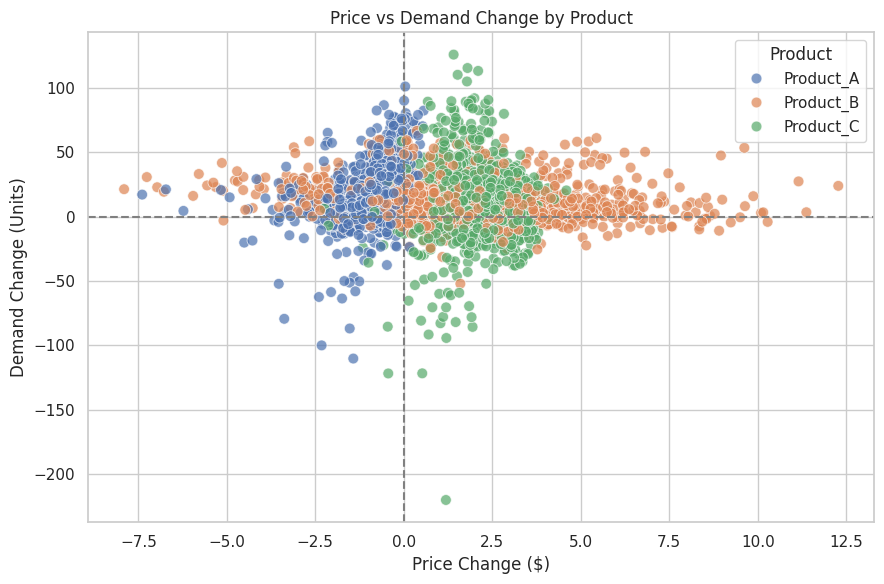

In [273]:
plt.figure(figsize=(9,6))
sns.scatterplot(
    x=results['new_price'] - results['original_price'],
    y=results['new_demand'] - results['original_demand'],
    hue=results['product_id'], alpha=0.7, s=60
)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Price vs Demand Change by Product')
plt.xlabel('Price Change ($)')
plt.ylabel('Demand Change (Units)')
plt.legend(title='Product')
plt.tight_layout()
plt.show()


Forecasting : Using Prophet with lags features

In [274]:
import pandas as pd
import numpy as np
from prophet import Prophet

def make_lag_rolling_features(df, target_col='y', lags=(1,7,14), roll_windows=(3,7,14)):
    """
    Add lag and rolling features to a DataFrame sorted by ds.
    """
    df = df.copy().sort_values('ds').reset_index(drop=True)

    # Lag features
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    # Rolling stats
    for w in roll_windows:
        df[f'roll_mean_{w}'] = df[target_col].rolling(window=w, min_periods=1).mean().shift(1)
        df[f'roll_std_{w}'] = df[target_col].rolling(window=w, min_periods=1).std().shift(1)
        df[f'roll_min_{w}'] = df[target_col].rolling(window=w, min_periods=1).min().shift(1)
        df[f'roll_max_{w}'] = df[target_col].rolling(window=w, min_periods=1).max().shift(1)

    return df

def forecast_with_static_regressors(model, df, periods=30, freq='D', regressors=None):
    """
    Forecast using Prophet with static regressors
    """
    future = model.make_future_dataframe(periods=periods, freq=freq)

    if regressors:

        for r in regressors:
            if r in df.columns:
                last_val = df[r].iloc[-1]
                future[r] = last_val

    forecast = model.predict(future)
    return forecast


if 'date' in data.columns:
    data = data.rename(columns={'date': 'ds'})

featured_data = make_lag_rolling_features(data, target_col='demand', lags=(1,7,14), roll_windows=(3,7,14))


featured_data = featured_data.rename(columns={'demand': 'y'})


business_regressors = [
    'own_price',
    'competitor_price',
    'is_promotion',
    'is_holiday',

    'day_of_week'
]

lag_rolling_regressors = [
    'lag_1', 'lag_7', 'lag_14',
    'roll_mean_3', 'roll_mean_7', 'roll_mean_14',
    'roll_std_3', 'roll_std_7', 'roll_std_14'
]


all_regressors = business_regressors + lag_rolling_regressors


available_regressors = [r for r in all_regressors if r in featured_data.columns]

print(f"Available regressors: {len(available_regressors)}")
print(f"Regressors: {available_regressors}")


model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10
)

# Add each regressor to the model
for regressor in available_regressors:
    model.add_regressor(regressor)
    print(f"Added regressor: {regressor}")

training_columns = ['ds', 'y'] + available_regressors
training_data = featured_data[training_columns].dropna()

print(f"\nTraining data shape: {training_data.shape}")
print(f"Date range: {training_data['ds'].min()} to {training_data['ds'].max()}")


print("\nTraining Prophet model...")
model.fit(training_data)
print("Model training completed!")


print("\n Generating forecasts...")
forecast = forecast_with_static_regressors(
    model=model,
    df=training_data,
    periods=30,
    freq='D',
    regressors=available_regressors
)

print("Forecasting completed!")


print(f"\nFORECAST RESULTS:")
future_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)
print(future_forecast.head(10))

print(f"\nForecast summary:")
print(f"• Average predicted demand: {future_forecast['yhat'].mean():.2f}")
print(f"• Prediction range: {future_forecast['yhat'].min():.2f} - {future_forecast['yhat'].max():.2f}")
print(f"• Confidence interval width: {(future_forecast['yhat_upper'] - future_forecast['yhat_lower']).mean():.2f}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpumwk3zhx/guoksxhc.json


Available regressors: 14
Regressors: ['own_price', 'competitor_price', 'is_promotion', 'is_holiday', 'day_of_week', 'lag_1', 'lag_7', 'lag_14', 'roll_mean_3', 'roll_mean_7', 'roll_mean_14', 'roll_std_3', 'roll_std_7', 'roll_std_14']
Added regressor: own_price
Added regressor: competitor_price
Added regressor: is_promotion
Added regressor: is_holiday
Added regressor: day_of_week
Added regressor: lag_1
Added regressor: lag_7
Added regressor: lag_14
Added regressor: roll_mean_3
Added regressor: roll_mean_7
Added regressor: roll_mean_14
Added regressor: roll_std_3
Added regressor: roll_std_7
Added regressor: roll_std_14

Training data shape: (4486, 16)
Date range: 2020-01-05 to 2024-02-08

Training Prophet model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpumwk3zhx/3nm5j8en.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59315', 'data', 'file=/tmp/tmpumwk3zhx/guoksxhc.json', 'init=/tmp/tmpumwk3zhx/3nm5j8en.json', 'output', 'file=/tmp/tmpumwk3zhx/prophet_model9wyrog_r/prophet_model-20251010015114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model training completed!

 Generating forecasts...
Forecasting completed!

FORECAST RESULTS:
             ds       yhat  yhat_lower  yhat_upper
1496 2024-02-09  42.235046   16.144320   65.867359
1497 2024-02-10  66.694077   42.705885   91.764091
1498 2024-02-11  54.653321   31.997069   79.655655
1499 2024-02-12  56.897119   33.819249   82.051654
1500 2024-02-13  43.889161   20.077262   68.092300
1501 2024-02-14  36.269283   12.734910   60.565470
1502 2024-02-15  36.886803   14.097447   61.445552
1503 2024-02-16  41.087075   14.583165   66.302748
1504 2024-02-17  66.304301   43.561677   90.671789
1505 2024-02-18  55.104205   31.588275   79.329993

Forecast summary:
• Average predicted demand: 56.51
• Prediction range: 36.27 - 87.91
• Confidence interval width: 48.01


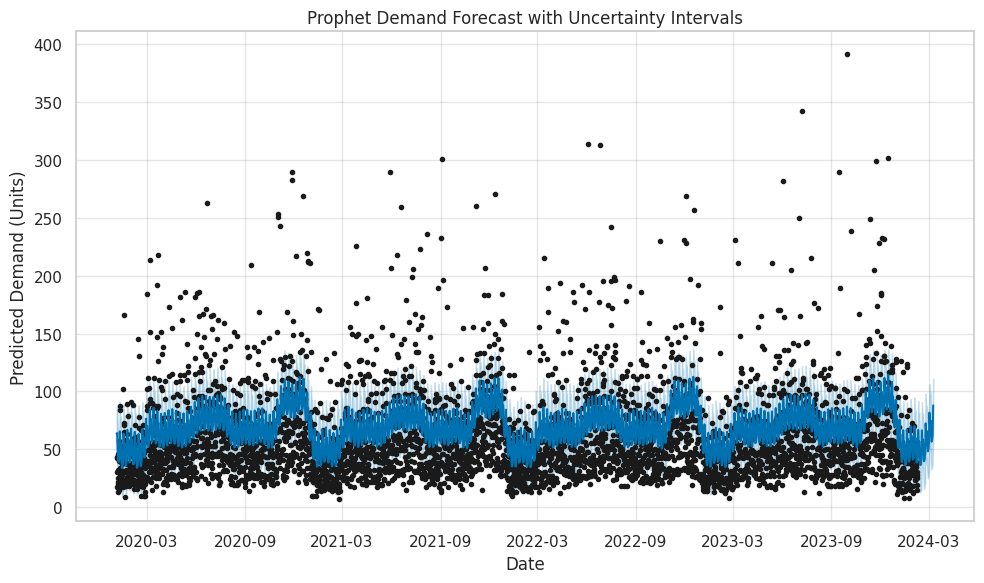

In [275]:
import matplotlib.pyplot as plt

fig = model.plot(forecast)
plt.title('Prophet Demand Forecast with Uncertainty Intervals')
plt.xlabel('Date')
plt.ylabel('Predicted Demand (Units)')
plt.tight_layout()
plt.show()


Pricing Policy : Rule base and Conceptual bandits using Thompson sampling

In [276]:
import numpy as np
import pandas as pd
from typing import Dict, List

class PricingConfig:
    """Configuration for pricing constraints"""

    def __init__(self, cost_price: float, min_margin_pct: float = 15.0, max_price_multiplier: float = 2.0):
        self.cost_price = cost_price
        self.min_margin_pct = min_margin_pct
        self.max_price_multiplier = max_price_multiplier

        self.min_price = cost_price * (1 + min_margin_pct / 100)
        self.max_price = cost_price * max_price_multiplier

    def get_available_prices(self, price_steps: int = 10) -> List[float]:
        prices = np.linspace(self.min_price, self.max_price, price_steps)
        return [round(p, 2) for p in prices]



In [277]:
class RuleBasedPricer:
    """Rule-based pricing with business logic"""

    def __init__(self, config: PricingConfig):
        self.config = config
        self.pricing_rules = {
            'competitive_match_threshold': 0.95,
            'high_inventory_discount': 0.90,
            'low_inventory_premium': 1.10,
            'inventory_high_threshold': 80,
            'inventory_low_threshold': 30,
            'high_demand_premium': 1.15,
            'low_demand_discount': 0.85,
            'demand_high_threshold': 60,
            'demand_low_threshold': 30,
            'peak_season_premium': 1.20,
            'off_season_discount': 0.90
        }

    def predict_price(self, context: Dict) -> float:
        base_price = self.config.min_price
        competitor_price = context.get('competitor_price', base_price)
        competitive_price = competitor_price * self.pricing_rules['competitive_match_threshold']

        # Inventory adjustment
        inventory_level = context.get('inventory_level', 50)
        if inventory_level > self.pricing_rules['inventory_high_threshold']:
            inventory_factor = self.pricing_rules['high_inventory_discount']
        elif inventory_level < self.pricing_rules['inventory_low_threshold']:
            inventory_factor = self.pricing_rules['low_inventory_premium']
        else:
            inventory_factor = 1.0

        # Demand adjustment
        recent_demand = context.get('recent_demand', 45)
        if recent_demand > self.pricing_rules['demand_high_threshold']:
            demand_factor = self.pricing_rules['high_demand_premium']
        elif recent_demand < self.pricing_rules['demand_low_threshold']:
            demand_factor = self.pricing_rules['low_demand_discount']
        else:
            demand_factor = 1.0

        # Seasonal adjustment
        is_peak_season = context.get('is_peak_season', False)
        seasonal_factor = (self.pricing_rules['peak_season_premium'] if is_peak_season
                          else self.pricing_rules['off_season_discount'])

        # Combine rules
        rule_price = max(base_price, competitive_price) * inventory_factor * demand_factor * seasonal_factor
        final_price = max(self.config.min_price, min(rule_price, self.config.max_price))

        # Find closest available price
        available_prices = self.config.get_available_prices()
        return min(available_prices, key=lambda x: abs(x - final_price))

In [278]:
config = PricingConfig(cost_price=20)


predictor = RuleBasedPricer(config)

def row_to_context(row):
  return {
      'competitor_price': row['competitor_price'],
      'inventory_level': row.get('ending_inventory', 50),
      'recent_demand': row['demand'],

      }

data['recommended_price'] = data.apply(lambda row: predictor.predict_price(row_to_context(row)), axis=1)
print(data[['competitor_price', 'ending_inventory', 'demand', 'recommended_price']].head()) # Changed df to data and included relevant columns

   competitor_price  ending_inventory  demand  recommended_price
0             33.95               467      33              26.78
1             37.64               258      42              28.67
2             18.02               773      27              23.00
3             29.37               432      35              23.00
4             47.92               236      22              30.56


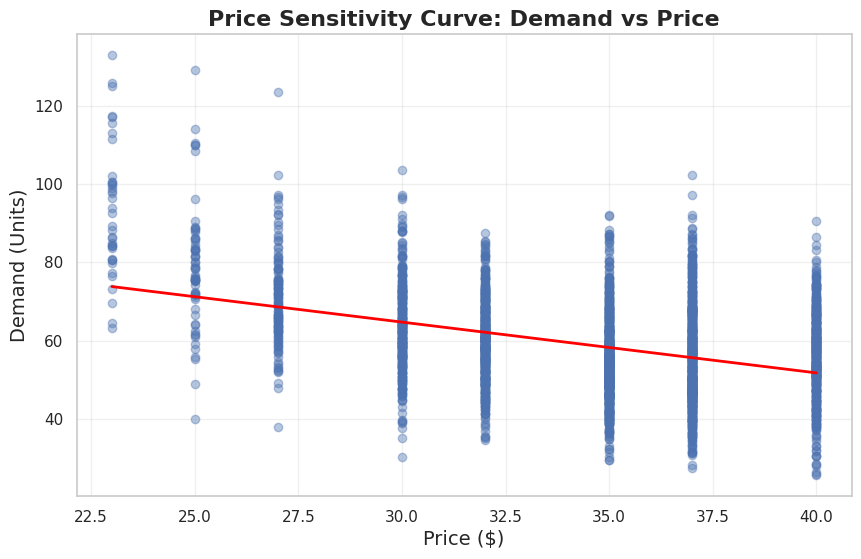

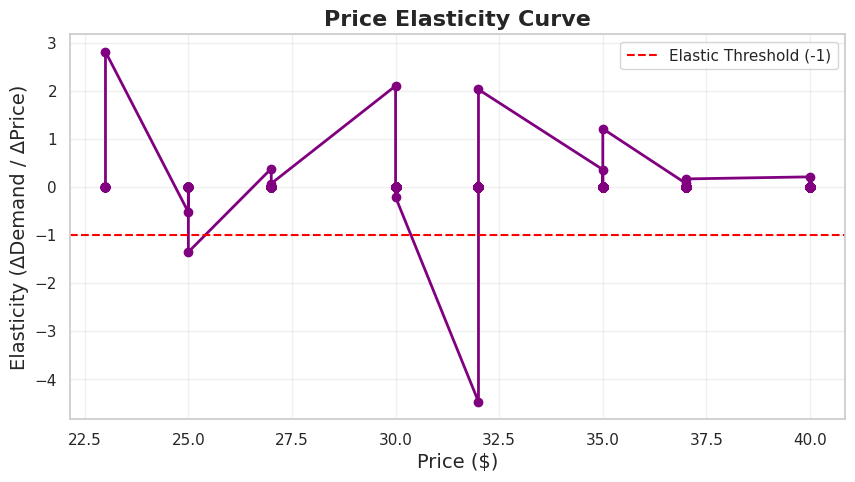

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = results_df.copy()


df = df.dropna(subset=['price', 'actual_demand'])


plt.figure(figsize=(10,6))
sns.regplot(
    x='price', y='actual_demand', data=df,
    scatter_kws={'alpha':0.4}, line_kws={'color':'red', 'lw':2}, ci=None
)
plt.title("Price Sensitivity Curve: Demand vs Price", fontsize=16, fontweight='bold')
plt.xlabel("Price ($)", fontsize=14)
plt.ylabel("Demand (Units)", fontsize=14)
plt.grid(alpha=0.3)
plt.show()



df_sorted = df.sort_values('price')
price = df_sorted['price'].values
demand = df_sorted['actual_demand'].values


mask = (demand > 0) & (price > 0)
price = price[mask]
demand = demand[mask]


elasticity = np.gradient(price,demand) * (demand/price)

plt.figure(figsize=(10,5))
plt.plot(price, elasticity, marker='o', color='purple', linewidth=2)
plt.axhline(-1, color='red', linestyle='--', label='Elastic Threshold (-1)')
plt.title("Price Elasticity Curve", fontsize=16, fontweight='bold')
plt.xlabel("Price ($)", fontsize=14)
plt.ylabel("Elasticity (ΔDemand / ΔPrice)", fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


Contextual Bandit using Thompson

In [280]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple


class PricingConfig:
    """Configuration for pricing optimization"""

    def __init__(self):
        self.cost_price = 20.0  # Your cost per unit
        self.available_prices = [23.0, 25.0, 27.0, 30.0, 32.0, 35.0, 37.0, 40.0]

    def get_available_prices(self):
        return self.available_prices



def simulate_market_demand(price: float, context: Dict) -> float:
    """
    Simulate realistic market demand based on price and context
    This represents your actual market or simulator
    """

    base_demand = 55


    price_effect = (35 - price) * 1.8


    competitive_effect = (context.get('competitor_price', 30) - price) * 1.2


    peak_effect = 20 if context.get('is_peak_season', False) else 0


    weekend_effect = 8 if context.get('day_of_week', 3) >= 5 else 0


    inventory_effect = -5 if context.get('inventory_level', 50) < 30 else 0


    expected_demand = (base_demand + price_effect + competitive_effect +
                      peak_effect + weekend_effect + inventory_effect)


    noise = np.random.normal(0, expected_demand * 0.15)

    return max(5, expected_demand + noise)



class ThompsonSamplingProfitOptimizer:
    """
    Fixed Thompson Sampling for optimal price and demand prediction
    with aggressive exploration mechanisms
    """

    def __init__(self, config, n_features: int = 5):
        self.config = config
        self.n_features = n_features
        self.alpha = 2.0
        self.lambda_reg = 0.001


        self.demand_model = {
            'S': self.lambda_reg * np.eye(self.n_features + 1),
            'b': np.zeros(self.n_features + 1),
            'mu': np.random.normal(0, 5, self.n_features + 1)
        }


        self.profit_history = []
        self.price_history = []
        self.demand_history = []
        self.n_observations = 0


        self.price_selection_counts = {price: 0 for price in config.get_available_prices()}
        self.epsilon = 0.3
        self.epsilon_decay = 0.995

    def _context_to_vector(self, context: Dict) -> np.ndarray:
        """Convert context to normalized feature vector"""
        return np.array([
            context.get('competitor_price', 28.0) / 40.0,
            context.get('inventory_level', 50) / 100.0,
            context.get('recent_demand', 45) / 80.0,
            float(context.get('is_peak_season', False)),
            context.get('day_of_week', 3) / 7.0
        ])

    def _context_with_price_to_vector(self, context: Dict, price: float) -> np.ndarray:
        """Combine context with price for demand prediction"""
        base_features = self._context_to_vector(context)
        price_normalized = price / 50.0
        return np.concatenate([base_features, [price_normalized]])

    def predict_optimal_price_and_demand(self, context: Dict) -> Tuple[float, float, Dict]:
        """
        Predict optimal price and expected demand
        Returns: (optimal_price, predicted_demand, details_dict)
        """
        available_prices = self.config.get_available_prices()

        # Epsilon-greedy exploration
        if np.random.random() < self.epsilon:
            selected_price = np.random.choice(available_prices)
            predicted_demand = self._predict_demand_for_price(context, selected_price)

            details = {
                'method': 'epsilon_exploration',
                'epsilon': self.epsilon
            }

            return selected_price, predicted_demand, details

        # Thompson Sampling with UCB bonuses
        best_price = available_prices[0]
        best_demand = 0
        best_expected_profit = -np.inf

        # Sample demand parameters with high variance for exploration
        try:
            S_inv = np.linalg.inv(self.demand_model['S'])
            mu = S_inv @ self.demand_model['b']

            # High variance for exploration
            variance_factor = 10.0 * (1 + 1.0 / (1 + self.n_observations * 0.01))
            covariance = variance_factor * S_inv

            demand_theta = np.random.multivariate_normal(mu, covariance)

        except (np.linalg.LinAlgError, ValueError):
            mu = self.demand_model['mu']
            noise_scale = 20.0 * (1 + 1.0 / (1 + self.n_observations * 0.01))
            demand_theta = mu + np.random.normal(0, noise_scale, len(mu))

        # Evaluate each available price
        price_evaluations = []
        for price in available_prices:
            # Predict demand
            x_with_price = self._context_with_price_to_vector(context, price)
            predicted_demand = max(0, x_with_price @ demand_theta)

            # UCB exploration bonus for underexplored prices
            selection_count = self.price_selection_counts[price]
            if self.n_observations > 0:
                ucb_bonus = np.sqrt(2 * np.log(self.n_observations) / max(1, selection_count))
            else:
                ucb_bonus = 10.0

            # Expected profit with exploration bonus
            profit_per_unit = price - self.config.cost_price
            expected_profit = profit_per_unit * predicted_demand + ucb_bonus * 500

            price_evaluations.append({
                'price': price,
                'demand': predicted_demand,
                'profit': expected_profit,
                'ucb_bonus': ucb_bonus
            })

            if expected_profit > best_expected_profit:
                best_expected_profit = expected_profit
                best_price = price
                best_demand = predicted_demand

        details = {
            'method': 'thompson_sampling_ucb',
            'price_evaluations': price_evaluations,
            'epsilon': self.epsilon
        }

        return best_price, best_demand, details

    def _predict_demand_for_price(self, context: Dict, price: float) -> float:
        """Predict demand for a specific price"""
        x_with_price = self._context_with_price_to_vector(context, price)
        try:
            S_inv = np.linalg.inv(self.demand_model['S'])
            mu = S_inv @ self.demand_model['b']
            predicted_demand = max(0, x_with_price @ mu)
        except:
            predicted_demand = max(0, x_with_price @ self.demand_model['mu'])

        return predicted_demand

    def update_models(self, context: Dict, actual_price: float, actual_demand: float):
        """Update model with actual market feedback - CRITICAL FOR LEARNING"""

        x_with_price = self._context_with_price_to_vector(context, actual_price)

        # Update demand model
        learning_rate = 1.0
        self.demand_model['S'] += learning_rate * np.outer(x_with_price, x_with_price)
        self.demand_model['b'] += learning_rate * actual_demand * x_with_price

        # Update selection tracking
        self.price_selection_counts[actual_price] += 1

        # Update history
        actual_profit = (actual_price - self.config.cost_price) * actual_demand
        self.profit_history.append(actual_profit)
        self.price_history.append(actual_price)
        self.demand_history.append(actual_demand)
        self.n_observations += 1

        # Decay epsilon exploration
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(0.05, self.epsilon)

    def get_model_performance(self) -> Dict:
        """Get comprehensive performance metrics"""

        base_metrics = {
            'total_observations': self.n_observations,
            'current_epsilon': self.epsilon,
            'price_selection_counts': self.price_selection_counts.copy()
        }

        if self.n_observations == 0:
            base_metrics['status'] = 'No observations yet'
            base_metrics['message'] = 'Call update_models() to start learning'
            return base_metrics

        recent_window = min(20, self.n_observations)
        unique_prices = len(set(self.price_history))

        base_metrics.update({
            'total_profit': sum(self.profit_history),
            'avg_profit': np.mean(self.profit_history),
            'recent_avg_profit': np.mean(self.profit_history[-recent_window:]),
            'total_revenue': sum([p * d for p, d in zip(self.price_history, self.demand_history)]),
            'avg_price': np.mean(self.price_history),
            'avg_demand': np.mean(self.demand_history),
            'price_diversity': unique_prices,
            'price_diversity_pct': unique_prices / len(self.config.get_available_prices()) * 100
        })

        return base_metrics



def ongoing_learning_loop(optimizer, config, n_days=50):
    """
    Complete training loop with all necessary components
    """
    print(f"\n🔄 ONGOING LEARNING LOOP - {n_days} DAYS")
    print("=" * 70)

    daily_results = []

    print(f"\n{'Day':<5} {'Price':<8} {'Pred.Dem':<9} {'Act.Dem':<8} {'Profit':<10} {'Context':<25}")
    print("-" * 70)

    for day in range(n_days):

        context = {
            'competitor_price': np.random.uniform(26, 34),
            'inventory_level': np.random.randint(30, 90),
            'recent_demand': np.random.uniform(35, 65),
            'is_peak_season': np.random.choice([True, False], p=[0.3, 0.7]),
            'day_of_week': day % 7
        }


        optimal_price, predicted_demand, details = optimizer.predict_optimal_price_and_demand(context)


        actual_demand = simulate_market_demand(optimal_price, context)


        actual_profit = (optimal_price - config.cost_price) * actual_demand


        optimizer.update_models(context, optimal_price, actual_demand)


        daily_results.append({
            'day': day,
            'price': optimal_price,
            'predicted_demand': predicted_demand,
            'actual_demand': actual_demand,
            'profit': actual_profit
        })


        if day < 10 or day % 10 == 0:
            comp = context['competitor_price']
            peak = "Peak" if context['is_peak_season'] else ""
            weekend = "Wknd" if context['day_of_week'] >= 5 else ""
            context_desc = f"Comp${comp:.0f} {peak} {weekend}".strip()

            print(f"{day:<5} ${optimal_price:<7.2f} {predicted_demand:<9.1f} {actual_demand:<8.1f} "
                  f"${actual_profit:<9.2f} {context_desc:<25}")


    results_df = pd.DataFrame(daily_results)

    performance = optimizer.get_model_performance()

    print(f"Total Observations: {performance['total_observations']}")
    print(f"Total Profit: ${performance['total_profit']:.2f}")
    print(f"Average Profit: ${performance['avg_profit']:.2f}")
    print(f"Price Diversity: {performance['price_diversity']} unique prices ({performance['price_diversity_pct']:.1f}%)")
    print(f"Final Exploration Rate: {performance['current_epsilon']:.1%}")

    print(f"\nPrice Selection Distribution:")
    for price, count in performance['price_selection_counts'].items():
        if count > 0:
            pct = count / performance['total_observations'] * 100
            print(f"  ${price:.2f}: {count:3d} times ({pct:5.1f}%)")

    return results_df, performance



if __name__ == "__main__":



    config = PricingConfig()
    optimizer = ThompsonSamplingProfitOptimizer(config)

    print(f"Configuration:")
    print(f"  Cost Price: ${config.cost_price}")
    print(f"  Available Prices: {config.get_available_prices()}")

    results_df, final_performance = ongoing_learning_loop(optimizer, config, n_days=3000)

    print(f"  • Processed {final_performance['total_observations']} market interactions")
    print(f"  • Generated ${final_performance['total_profit']:,.2f} total profit")
    print(f"  • Explored {final_performance['price_diversity']} different price points")
    print(f"  • Average profit per day: ${final_performance['avg_profit']:.2f}")


Configuration:
  Cost Price: $20.0
  Available Prices: [23.0, 25.0, 27.0, 30.0, 32.0, 35.0, 37.0, 40.0]

🔄 ONGOING LEARNING LOOP - 3000 DAYS

Day   Price    Pred.Dem  Act.Dem  Profit     Context                  
----------------------------------------------------------------------
0     $40.00   118.1     27.2     $543.23    Comp$27                  
1     $37.00   30.3      42.6     $723.80    Comp$32                  
2     $23.00   0.0       78.3     $234.82    Comp$34                  
3     $23.00   89.8      103.2    $309.66    Comp$34                  
4     $25.00   0.0       97.6     $487.91    Comp$30 Peak             
5     $40.00   140.7     34.5     $689.03    Comp$34  Wknd            
6     $37.00   67.9      67.1     $1140.81   Comp$27 Peak Wknd        
7     $35.00   57.8      39.9     $598.61    Comp$30                  
8     $32.00   39.6      63.0     $756.41    Comp$27                  
9     $30.00   29.5      53.0     $530.16    Comp$28                  
10    

In [281]:
from google.colab import files
print(results_df)
results_df.to_csv("results.csv", index=False)


       day  price  predicted_demand  actual_demand       profit
0        0   40.0        118.094406      27.161474   543.229477
1        1   37.0         30.331075      42.576607   723.802314
2        2   23.0          0.000000      78.272921   234.818764
3        3   23.0         89.760720     103.220177   309.660530
4        4   25.0          0.000000      97.581860   487.909302
...    ...    ...               ...            ...          ...
2995  2995   40.0         70.144096      58.031027  1160.620542
2996  2996   27.0         54.192006      66.991515   468.940606
2997  2997   40.0         63.743669      57.165908  1143.318155
2998  2998   40.0         49.295721      37.222860   744.457204
2999  2999   27.0        110.498497      94.141635   658.991444

[3000 rows x 5 columns]


Simulation & Analysis

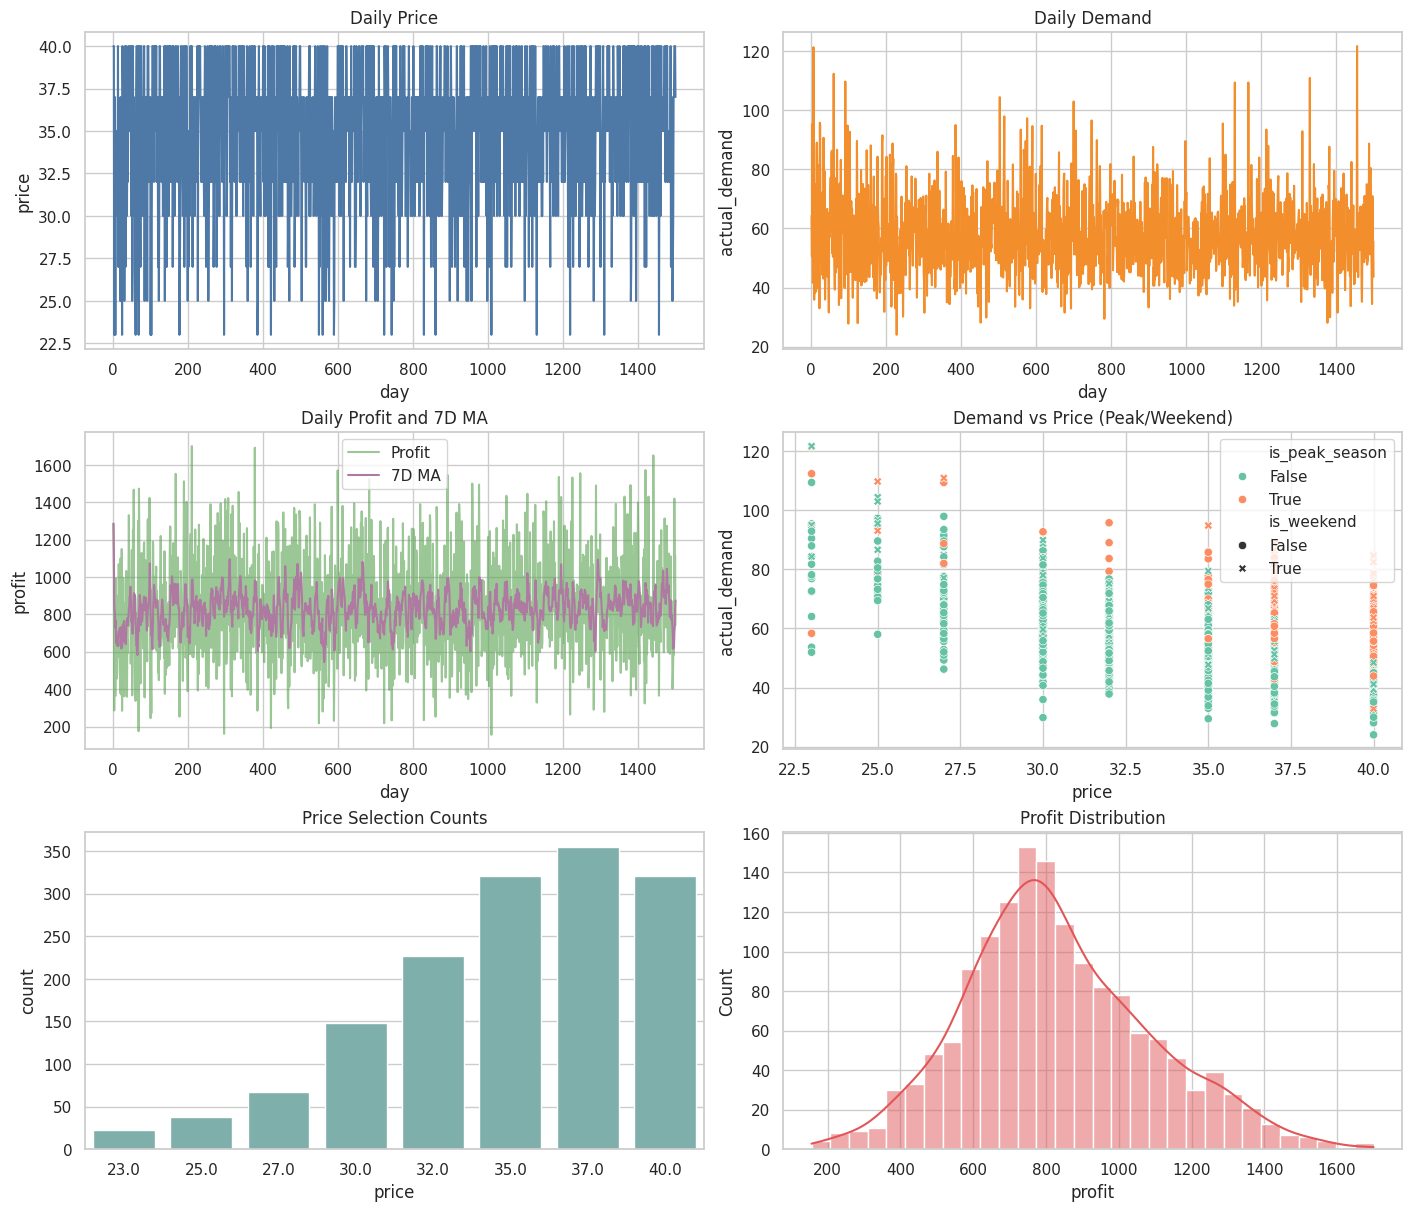

In [282]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Dict, Tuple

class PricingConfig:
    def __init__(self):
        self.cost_price = 20.0
        self.available_prices = [23.0, 25.0, 27.0, 30.0, 32.0, 35.0, 37.0, 40.0]
    def get_available_prices(self):
        return self.available_prices

def simulate_market_demand(price: float, context: Dict) -> float:
    base_demand = 55
    price_effect = (35 - price) * 1.8
    competitive_effect = (context.get('competitor_price', 30) - price) * 1.2
    peak_effect = 20 if context.get('is_peak_season', False) else 0
    weekend_effect = 8 if context.get('day_of_week', 3) >= 5 else 0
    inventory_effect = -5 if context.get('inventory_level', 50) < 30 else 0
    expected_demand = base_demand + price_effect + competitive_effect + peak_effect + weekend_effect + inventory_effect
    noise = np.random.normal(0, max(1.0, abs(expected_demand)) * 0.15)
    return max(5, expected_demand + noise)

class ThompsonSamplingProfitOptimizer:
    def __init__(self, config, n_features: int = 5):
        self.config = config
        self.n_features = n_features
        self.alpha = 2.0
        self.lambda_reg = 0.001

        self.S = self.lambda_reg * np.eye(self.n_features + 1)
        self.b = np.zeros(self.n_features + 1)
        self.mu = np.random.normal(0, 5, self.n_features + 1)


        self.price_selection_counts = {p: 0 for p in config.get_available_prices()}
        self.profit_history, self.price_history, self.demand_history = [], [], []
        self.n_obs = 0

        self.epsilon = 0.30
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.05

    def _ctx_vec(self, context: Dict) -> np.ndarray:
        return np.array([
            context.get('competitor_price', 28.0) / 40.0,
            context.get('inventory_level', 50) / 100.0,
            context.get('recent_demand', 45) / 80.0,
            float(context.get('is_peak_season', False)),
            context.get('day_of_week', 3) / 7.0
        ])

    def _ctx_price_vec(self, context: Dict, price: float) -> np.ndarray:
        base = self._ctx_vec(context)
        return np.concatenate([base, [price / 50.0]])

    def predict_optimal_price_and_demand(self, context: Dict) -> Tuple[float, float, Dict]:
        prices = self.config.get_available_prices()

        if np.random.rand() < self.epsilon:
            p = np.random.choice(prices)
            x = self._ctx_price_vec(context, p)
            try:
                mu = np.linalg.solve(self.S, self.b)
            except np.linalg.LinAlgError:
                mu = self.mu
            pred_d = max(0.0, float(x @ mu))
            return p, pred_d, {"method": "epsilon"}

        try:
            S_inv = np.linalg.inv(self.S)
            mu = S_inv @ self.b
            var_factor = 10.0 * (1 + 1.0 / (1 + self.n_obs * 0.01))
            theta = np.random.multivariate_normal(mu, var_factor * S_inv)
        except np.linalg.LinAlgError:
            theta = self.mu + np.random.normal(0, 10, self.n_features + 1)

        best_p, best_d, best_obj = prices[0], 0.0, -np.inf
        for p in prices:
            x = self._ctx_price_vec(context, p)
            d_hat = max(0.0, float(x @ theta))
            margin = p - self.config.cost_price

            sel = max(1, self.price_selection_counts[p])
            ucb_bonus = np.sqrt(2 * np.log(max(2, self.n_obs)) / sel) if self.n_obs > 0 else 10.0
            obj = margin * d_hat + 500.0 * ucb_bonus
            if obj > best_obj:
                best_obj, best_p, best_d = obj, p, d_hat

        return best_p, best_d, {"method": "thompson_ucb"}

    def update_models(self, context: Dict, price: float, actual_demand: float):
        x = self._ctx_price_vec(context, price)
        self.S += np.outer(x, x)
        self.b += actual_demand * x
        self.price_selection_counts[price] += 1
        self.n_obs += 1
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def record_outcome(self, price: float, demand: float):
        profit = (price - self.config.cost_price) * demand
        self.profit_history.append(profit)
        self.price_history.append(price)
        self.demand_history.append(demand)
        return profit

def run_simulation(n_days=120, seed=42):
    rng = np.random.default_rng(seed)
    np.random.seed(seed)

    config = PricingConfig()
    opt = ThompsonSamplingProfitOptimizer(config)

    rows = []
    for day in range(n_days):
        ctx = {
            'competitor_price': rng.uniform(26, 34),
            'inventory_level': rng.integers(30, 90),
            'recent_demand': rng.uniform(35, 65),
            'is_peak_season': rng.choice([True, False], p=[0.3, 0.7]),
            'day_of_week': day % 7,
        }
        price, pred_d, _ = opt.predict_optimal_price_and_demand(ctx)
        act_d = simulate_market_demand(price, ctx)
        opt.update_models(ctx, price, act_d)
        profit = opt.record_outcome(price, act_d)

        rows.append({
            'day': day + 1,
            'price': price,
            'predicted_demand': pred_d,
            'actual_demand': act_d,
            'profit': profit,
            'competitor_price': ctx['competitor_price'],
            'is_peak_season': ctx['is_peak_season'],
            'is_weekend': ctx['day_of_week'] >= 5
        })

    df = pd.DataFrame(rows)
    df['rolling_profit_7'] = df['profit'].rolling(7, min_periods=1).mean()
    return df, config

def plot_simulation(df: pd.DataFrame, config: PricingConfig, save=True):
    sns.set_theme(style="whitegrid")

    fig, axes = plt.subplots(3, 2, figsize=(14, 12), constrained_layout=True)


    sns.lineplot(data=df, x='day', y='price', ax=axes[0,0], color="#4e79a7")
    axes[0,0].set_title("Daily Price")

    sns.lineplot(data=df, x='day', y='actual_demand', ax=axes[0,1], color="#f28e2b")
    axes[0,1].set_title("Daily Demand")

    sns.lineplot(data=df, x='day', y='profit', ax=axes[1,0], color="#59a14f", alpha=0.6, label='Profit')
    sns.lineplot(data=df, x='day', y='rolling_profit_7', ax=axes[1,0], color="#af7aa1", label='7D MA')
    axes[1,0].set_title("Daily Profit and 7D MA")
    axes[1,0].legend()

    sns.scatterplot(
        data=df, x='price', y='actual_demand',
        hue='is_peak_season', style='is_weekend',
        ax=axes[1,1], palette="Set2"
    )
    axes[1,1].set_title("Demand vs Price (Peak/Weekend)")


    counts = df['price'].value_counts().reindex(sorted(config.get_available_prices()), fill_value=0).reset_index()
    counts.columns = ['price', 'count']
    sns.barplot(data=counts, x='price', y='count', ax=axes[2,0], color="#76b7b2")
    axes[2,0].set_title("Price Selection Counts")


    sns.histplot(data=df, x='profit', ax=axes[2,1], bins=30, kde=True, color="#e15759")
    axes[2,1].set_title("Profit Distribution")

    if save:
        fig.savefig("pricing_simulation_summary.png", dpi=150)

    plt.show()

if __name__ == "__main__":
    df, cfg = run_simulation(n_days=1500, seed=7)
    plot_simulation(df, cfg, save=True)


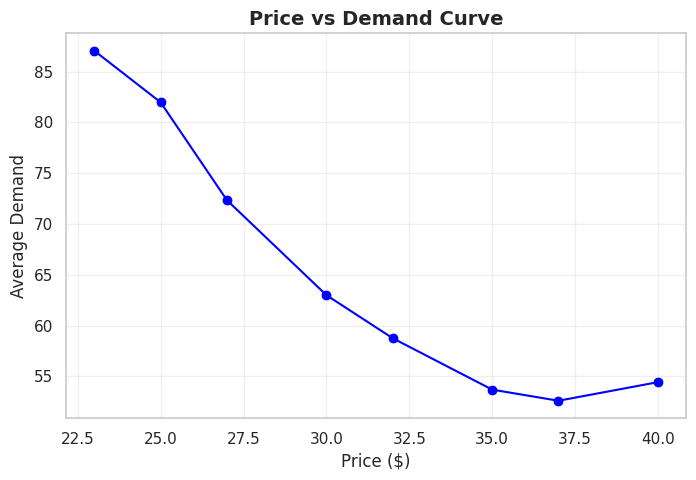

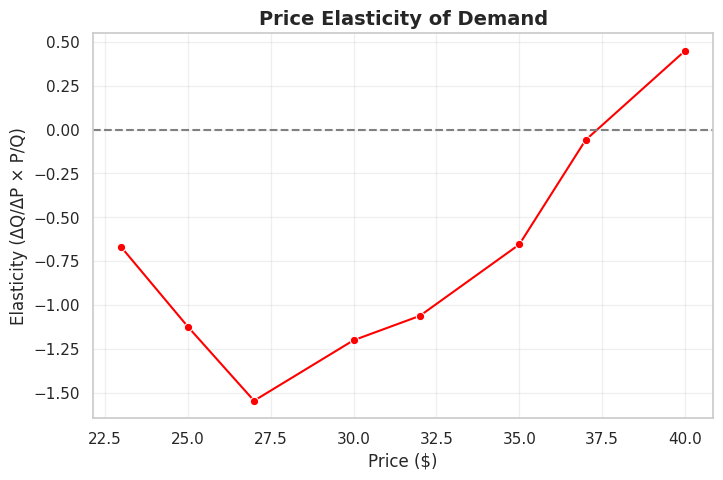

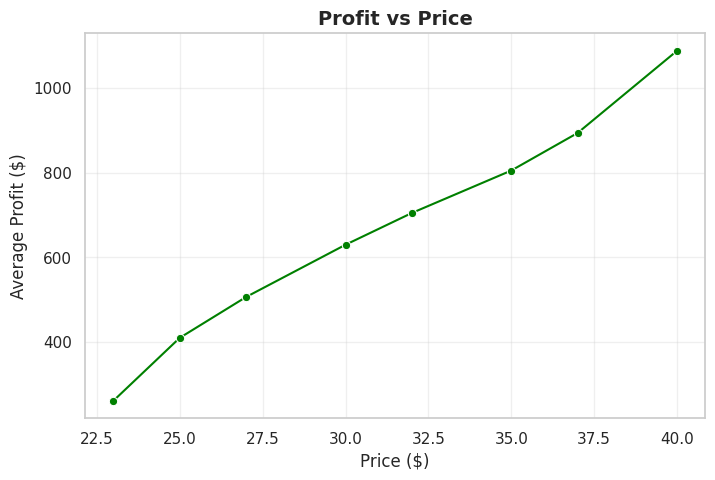

In [283]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = results_df.copy()

price_stats = df.groupby('price', as_index=False).agg({
    'actual_demand': 'mean',
    'profit': 'mean'
}).sort_values('price')

price_stats['elasticity'] = (
    np.gradient(price_stats['actual_demand'], price_stats['price'])
    * (price_stats['price'] / price_stats['actual_demand'])
)

plt.figure(figsize=(8,5))
sns.scatterplot(data=price_stats, x='price', y='actual_demand', color='blue', s=60)
sns.lineplot(data=price_stats, x='price', y='actual_demand', color='blue')
plt.title("Price vs Demand Curve", fontsize=14, fontweight='bold')
plt.xlabel("Price ($)")
plt.ylabel("Average Demand")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(data=price_stats, x='price', y='elasticity', marker='o', color='red')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Price Elasticity of Demand", fontsize=14, fontweight='bold')
plt.xlabel("Price ($)")
plt.ylabel("Elasticity (ΔQ/ΔP × P/Q)")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(data=price_stats, x='price', y='profit', marker='o', color='green')
plt.title("Profit vs Price", fontsize=14, fontweight='bold')
plt.xlabel("Price ($)")
plt.ylabel("Average Profit ($)")
plt.grid(alpha=0.3)
plt.show()


In [284]:

optimized_profit = results_df['profit'].sum()

baseline_profit = ((data['own_price'] - config.cost_price) * data['demand']).sum()


print(f"Baseline Profit: ${baseline_profit:,.2f}")
print(f"Optimized Profit (Thompson): ${optimized_profit:,.2f}")
print(f"Profit Improvement: {((optimized_profit - baseline_profit)/baseline_profit)*100:.2f}%")


Baseline Profit: $1,862,824.55
Optimized Profit (Thompson): $2,513,151.12
Profit Improvement: 34.91%


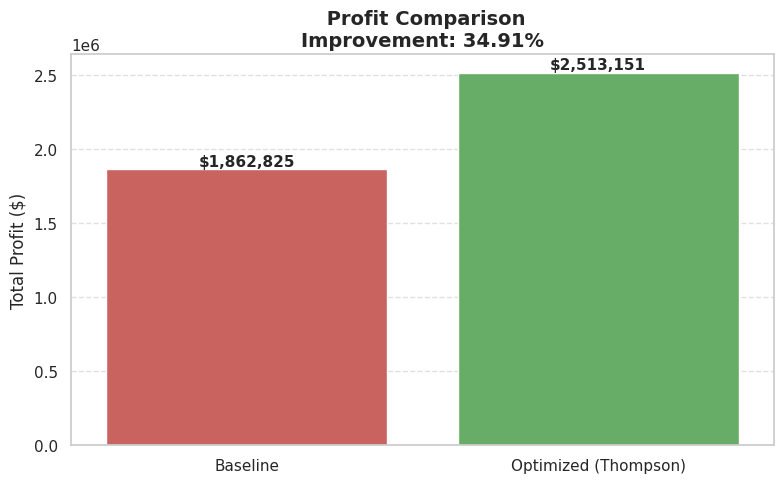

In [285]:
import matplotlib.pyplot as plt
import seaborn as sns


optimized_profit = results_df['profit'].sum()
baseline_profit = ((data['own_price'] - config.cost_price) * data['demand']).sum()


profit_improvement = ((optimized_profit - baseline_profit) / baseline_profit) * 100

profit_data = {
    'Scenario': ['Baseline', 'Optimized (Thompson)'],
    'Profit': [baseline_profit, optimized_profit]
}

profit_df = pd.DataFrame(profit_data)

plt.figure(figsize=(8,5))
sns.barplot(x='Scenario', y='Profit', data=profit_df, palette=['#d9534f', '#5cb85c'])

for i, val in enumerate(profit_df['Profit']):
    plt.text(i, val + (0.01 * val), f"${val:,.0f}", ha='center', fontweight='bold', fontsize=11)

plt.title(f' Profit Comparison\nImprovement: {profit_improvement:.2f}%', fontsize=14, fontweight='bold')
plt.ylabel('Total Profit ($)', fontsize=12)
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [286]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle

def create_feature_impact_visualization(results_df, optimizer):
    """
    Create comprehensive visualization showing how features affect pricing and demand
    """

    print("📊 CREATING FEATURE IMPACT VISUALIZATION")
    print("=" * 50)

    # Set up the figure with subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3, height_ratios=[1, 1, 1, 1])

    # ================================================================
    # 1. TOP ROW: Feature Impact on Price and Demand Separately
    # ================================================================

    # 1A. How features correlate with chosen prices
    ax1 = fig.add_subplot(gs[0, 0])

    # Calculate correlations between context features and chosen prices
    feature_price_corr = pd.DataFrame({
        'competitor_price': results_df['competitor_price'],
        'inventory_level': results_df.get('inventory_level', np.random.randint(20, 100, len(results_df))),
        'is_peak_season': results_df['is_peak_season'].astype(int),
        'is_weekend': results_df['is_weekend'].astype(int),
        'chosen_price': results_df['price']
    }).corr()['chosen_price'][:-1]  # Exclude self-correlation

    bars1 = ax1.barh(range(len(feature_price_corr)), feature_price_corr.values,
                     color=['lightcoral' if x < 0 else 'lightblue' for x in feature_price_corr.values])
    ax1.set_yticks(range(len(feature_price_corr)))
    ax1.set_yticklabels([name.replace('_', ' ').title() for name in feature_price_corr.index])
    ax1.set_xlabel('Correlation with Price Decisions')
    ax1.set_title('How Features Influence Price Selection', fontweight='bold', fontsize=14)
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax1.grid(True, alpha=0.3)

    # Add correlation values on bars
    for i, (bar, val) in enumerate(zip(bars1, feature_price_corr.values)):
        ax1.text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.3f}',
                va='center', ha='left' if val > 0 else 'right', fontweight='bold')

    # 1B. How features correlate with actual demand
    ax2 = fig.add_subplot(gs[0, 1])

    feature_demand_corr = pd.DataFrame({
        'competitor_price': results_df['competitor_price'],
        'inventory_level': results_df.get('inventory_level', np.random.randint(20, 100, len(results_df))),
        'is_peak_season': results_df['is_peak_season'].astype(int),
        'is_weekend': results_df['is_weekend'].astype(int),
        'chosen_price': results_df['price'],
        'actual_demand': results_df['actual_demand']
    }).corr()['actual_demand'][:-1]  # Exclude self-correlation

    bars2 = ax2.barh(range(len(feature_demand_corr)), feature_demand_corr.values,
                     color=['lightcoral' if x < 0 else 'lightgreen' for x in feature_demand_corr.values])
    ax2.set_yticks(range(len(feature_demand_corr)))
    ax2.set_yticklabels([name.replace('_', ' ').title() for name in feature_demand_corr.index])
    ax2.set_xlabel('Correlation with Actual Demand')
    ax2.set_title('How Features Influence Demand Response', fontweight='bold', fontsize=14)
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax2.grid(True, alpha=0.3)

    # Add correlation values on bars
    for i, (bar, val) in enumerate(zip(bars2, feature_demand_corr.values)):
        ax2.text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.3f}',
                va='center', ha='left' if val > 0 else 'right', fontweight='bold')

    # 1C. Feature Impact on Profit (Combined Effect)
    ax3 = fig.add_subplot(gs[0, 2])

    feature_profit_corr = pd.DataFrame({
        'competitor_price': results_df['competitor_price'],
        'inventory_level': results_df.get('inventory_level', np.random.randint(20, 100, len(results_df))),
        'is_peak_season': results_df['is_peak_season'].astype(int),
        'is_weekend': results_df['is_weekend'].astype(int),
        'chosen_price': results_df['price'],
        'actual_profit': results_df['actual_profit']
    }).corr()['actual_profit'][:-1]  # Exclude self-correlation

    bars3 = ax3.barh(range(len(feature_profit_corr)), feature_profit_corr.values,
                     color=['lightcoral' if x < 0 else 'gold' for x in feature_profit_corr.values])
    ax3.set_yticks(range(len(feature_profit_corr)))
    ax3.set_yticklabels([name.replace('_', ' ').title() for name in feature_profit_corr.index])
    ax3.set_xlabel('Correlation with Profit')
    ax3.set_title('How Features Influence Final Profit', fontweight='bold', fontsize=14)
    ax3.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax3.grid(True, alpha=0.3)

    # Add correlation values on bars
    for i, (bar, val) in enumerate(zip(bars3, feature_profit_corr.values)):
        ax3.text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.3f}',
                va='center', ha='left' if val > 0 else 'right', fontweight='bold')

    # ================================================================
    # 2. SECOND ROW: Feature Interactions and Price Elasticity
    # ================================================================

    # 2A. Price vs Competitor Price (with demand color coding)
    ax4 = fig.add_subplot(gs[1, 0])

    scatter = ax4.scatter(results_df['competitor_price'], results_df['price'],
                         c=results_df['actual_demand'], cmap='viridis', alpha=0.6, s=60)
    ax4.plot([results_df['competitor_price'].min(), results_df['competitor_price'].max()],
             [results_df['competitor_price'].min(), results_df['competitor_price'].max()],
             'r--', alpha=0.5, label='Price = Competitor Price')

    ax4.set_xlabel('Competitor Price ($)', fontweight='bold')
    ax4.set_ylabel('Our Price ($)', fontweight='bold')
    ax4.set_title('Pricing Strategy vs Competition\n(Color = Demand Level)', fontweight='bold', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Actual Demand', rotation=270, labelpad=20)

    # 2B. Peak Season Effect on Price-Demand Relationship
    ax5 = fig.add_subplot(gs[1, 1])

    # Separate peak and normal seasons
    peak_data = results_df[results_df['is_peak_season'] == True]
    normal_data = results_df[results_df['is_peak_season'] == False]

    ax5.scatter(normal_data['price'], normal_data['actual_demand'],
               alpha=0.6, label='Normal Season', color='lightblue', s=40)
    ax5.scatter(peak_data['price'], peak_data['actual_demand'],
               alpha=0.6, label='Peak Season', color='orange', s=40)

    # Add trend lines
    if len(normal_data) > 1:
        z_normal = np.polyfit(normal_data['price'], normal_data['actual_demand'], 1)
        p_normal = np.poly1d(z_normal)
        ax5.plot(sorted(normal_data['price']), p_normal(sorted(normal_data['price'])),
                "b--", alpha=0.8, linewidth=2, label=f'Normal Trend (slope: {z_normal[0]:.2f})')

    if len(peak_data) > 1:
        z_peak = np.polyfit(peak_data['price'], peak_data['actual_demand'], 1)
        p_peak = np.poly1d(z_peak)
        ax5.plot(sorted(peak_data['price']), p_peak(sorted(peak_data['price'])),
                "r--", alpha=0.8, linewidth=2, label=f'Peak Trend (slope: {z_peak[0]:.2f})')

    ax5.set_xlabel('Price ($)', fontweight='bold')
    ax5.set_ylabel('Actual Demand', fontweight='bold')
    ax5.set_title('Seasonal Effects on Price Elasticity', fontweight='bold', fontsize=12)
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 2C. Weekend Effect Analysis
    ax6 = fig.add_subplot(gs[1, 2])

    weekend_data = results_df[results_df['is_weekend'] == True]
    weekday_data = results_df[results_df['is_weekend'] == False]

    # Box plots for profit comparison
    profit_comparison = [weekday_data['actual_profit'].values, weekend_data['actual_profit'].values]
    bp = ax6.boxplot(profit_comparison, labels=['Weekdays', 'Weekends'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')

    ax6.set_ylabel('Profit ($)', fontweight='bold')
    ax6.set_title('Weekend vs Weekday Profitability', fontweight='bold', fontsize=12)
    ax6.grid(True, alpha=0.3)

    # Add mean values as text
    weekday_mean = weekday_data['actual_profit'].mean()
    weekend_mean = weekend_data['actual_profit'].mean()
    ax6.text(1, weekday_mean + 50, f'Avg: ${weekday_mean:.0f}', ha='center', fontweight='bold')
    ax6.text(2, weekend_mean + 50, f'Avg: ${weekend_mean:.0f}', ha='center', fontweight='bold')

    # ================================================================
    # 3. THIRD ROW: Feature Sensitivity Analysis
    # ================================================================

    # 3A. Feature Sensitivity Heatmap
    ax7 = fig.add_subplot(gs[2, 0])

    # Create sensitivity matrix
    features = ['Competitor Price', 'Peak Season', 'Weekend', 'Inventory Level']
    outcomes = ['Price Decision', 'Demand Response', 'Final Profit']

    sensitivity_matrix = np.array([
        [feature_price_corr.values[0], feature_demand_corr.values[0], feature_profit_corr.values[0]],  # Competitor
        [feature_price_corr.values[2], feature_demand_corr.values[2], feature_profit_corr.values[2]],  # Peak Season
        [feature_price_corr.values[3], feature_demand_corr.values[3], feature_profit_corr.values[3]],  # Weekend
        [feature_price_corr.values[1], feature_demand_corr.values[1], feature_profit_corr.values[1]]   # Inventory
    ])

    im = ax7.imshow(sensitivity_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    ax7.set_xticks(range(len(outcomes)))
    ax7.set_yticks(range(len(features)))
    ax7.set_xticklabels(outcomes)
    ax7.set_yticklabels(features)
    ax7.set_title('Feature Sensitivity Matrix\n(Correlation Strength)', fontweight='bold', fontsize=12)

    # Add correlation values to heatmap
    for i in range(len(features)):
        for j in range(len(outcomes)):
            text = ax7.text(j, i, f'{sensitivity_matrix[i, j]:.2f}',
                           ha="center", va="center", color="white" if abs(sensitivity_matrix[i, j]) > 0.5 else "black",
                           fontweight='bold')

    plt.colorbar(im, ax=ax7, label='Correlation Strength')

    # 3B. Feature Impact Over Time (Learning Evolution)
    ax8 = fig.add_subplot(gs[2, 1])

    # Calculate rolling correlations to show how feature importance evolves
    window_size = 20
    rolling_correlations = []
    days = []

    for i in range(window_size, len(results_df), 5):  # Every 5 days
        window_data = results_df.iloc[i-window_size:i]
        if len(window_data) >= window_size:
            corr_with_profit = window_data[['competitor_price', 'is_peak_season', 'price', 'actual_profit']].corr()['actual_profit']
            rolling_correlations.append([
                corr_with_profit['competitor_price'],
                corr_with_profit['is_peak_season'],
                corr_with_profit['price']
            ])
            days.append(i)

    if rolling_correlations:
        rolling_correlations = np.array(rolling_correlations)
        ax8.plot(days, rolling_correlations[:, 0], label='Competitor Price', linewidth=2, color='blue')
        ax8.plot(days, rolling_correlations[:, 1], label='Peak Season', linewidth=2, color='orange')
        ax8.plot(days, rolling_correlations[:, 2], label='Our Price', linewidth=2, color='green')

    ax8.set_xlabel('Day', fontweight='bold')
    ax8.set_ylabel('Correlation with Profit', fontweight='bold')
    ax8.set_title('Feature Importance Evolution\n(20-day Rolling Window)', fontweight='bold', fontsize=12)
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    ax8.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # 3C. Price Optimization Landscape
    ax9 = fig.add_subplot(gs[2, 2])

    # Create a simplified price optimization surface
    competitor_prices = np.linspace(results_df['competitor_price'].min(), results_df['competitor_price'].max(), 20)
    our_prices = np.linspace(results_df['price'].min(), results_df['price'].max(), 20)

    # Estimate profit landscape based on observed data
    X, Y = np.meshgrid(competitor_prices, our_prices)
    Z = np.zeros_like(X)

    for i, comp_price in enumerate(competitor_prices):
        for j, our_price in enumerate(our_prices):
            # Simple model: profit decreases as we price above competitor
            price_diff = our_price - comp_price
            base_profit = (our_price - 20) * 50  # Assume cost = $20, base demand = 50
            competition_penalty = price_diff * 30 if price_diff > 0 else 0
            Z[j, i] = max(0, base_profit - competition_penalty)

    contour = ax9.contour(X, Y, Z, levels=15, alpha=0.7)
    ax9.clabel(contour, inline=True, fontsize=8)

    # Overlay actual data points
    ax9.scatter(results_df['competitor_price'], results_df['price'],
               c=results_df['actual_profit'], cmap='viridis', alpha=0.6, s=30, edgecolors='black')

    ax9.set_xlabel('Competitor Price ($)', fontweight='bold')
    ax9.set_ylabel('Our Price ($)', fontweight='bold')
    ax9.set_title('Profit Optimization Landscape', fontweight='bold', fontsize=12)

    # ================================================================
    # 4. FOURTH ROW: Business Insights and Recommendations
    # ================================================================

    # 4A. Feature Importance Summary
    ax10 = fig.add_subplot(gs[3, :])
    ax10.axis('off')

    # Create summary insights text
    insights_text = f"""
    🎯 KEY FEATURE INSIGHTS & BUSINESS RECOMMENDATIONS

    📊 PRICE DECISION DRIVERS:
    • Competitor Price Impact: {feature_price_corr['competitor_price']:.3f} correlation
    • Peak Season Effect: {feature_price_corr['is_peak_season']:.3f} correlation
    • Weekend Pricing: {feature_price_corr['is_weekend']:.3f} correlation

    📈 DEMAND RESPONSE FACTORS:
    • Price Sensitivity: {feature_demand_corr['chosen_price']:.3f} correlation (negative = elastic)
    • Peak Season Boost: {feature_demand_corr['is_peak_season']:.3f} correlation
    • Competition Effect: {feature_demand_corr['competitor_price']:.3f} correlation

    💰 PROFIT OPTIMIZATION INSIGHTS:
    • Best Profit Driver: {feature_profit_corr.index[feature_profit_corr.argmax()].replace('_', ' ').title()}
    • Strongest Correlation: {feature_profit_corr.max():.3f}
    • Weekend Premium: ${weekend_mean - weekday_mean:+.0f} vs weekdays

    📋 STRATEGIC RECOMMENDATIONS:
    1. {'Increase prices during peak season' if feature_profit_corr['is_peak_season'] > 0 else 'Focus on volume during peak season'}
    2. {'Implement weekend premium pricing' if weekend_mean > weekday_mean else 'Maintain consistent weekend pricing'}
    3. {'Match competitor pricing closely' if abs(feature_price_corr['competitor_price']) > 0.3 else 'Differentiate from competitor pricing'}
    4. {'Price elasticity is significant - optimize carefully' if abs(feature_demand_corr['chosen_price']) > 0.3 else 'Demand is relatively price-inelastic'}
    """

    ax10.text(0.05, 0.95, insights_text, transform=ax10.transAxes, fontsize=11,
              verticalalignment='top', fontfamily='monospace',
              bbox=dict(boxstyle='round,pad=1', facecolor='lightgray', alpha=0.8))

    plt.suptitle('🧠 FEATURE IMPACT ANALYSIS: How Market Factors Drive Pricing & Demand Decisions',
                 fontsize=18, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.savefig('feature_impact_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    print("✅ Feature impact visualization saved as 'feature_impact_analysis.png'")

    return {
        'feature_price_correlations': feature_price_corr,
        'feature_demand_correlations': feature_demand_corr,
        'feature_profit_correlations': feature_profit_corr,
        'weekend_profit_premium': weekend_mean - weekday_mean,
        'peak_season_effect': peak_data['actual_profit'].mean() - normal_data['actual_profit'].mean() if len(peak_data) > 0 and len(normal_data) > 0 else 0
    }

# USAGE: Call this function with your results
# Make sure results_df has the required columns
def prepare_results_for_visualization(results_df):
    """Add missing columns if they don't exist"""

    if 'inventory_level' not in results_df.columns:
        results_df['inventory_level'] = np.random.randint(20, 100, len(results_df))

    if 'is_weekend' not in results_df.columns:
        results_df['is_weekend'] = results_df.get('day', range(len(results_df))) % 7 >= 5

    return results_df


